<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/banner.png" width="1200"></center>
<br>
<center><h1>Flower with TPUs - Advanced augmentations</h1></center>
<br>

#### The goal of this notebook is to show one way how we can better control our augmentation functions and keep TPU performance.
#### This is supposed to be something closer to `imgaug` and `albumentations` that most people are familiar with.
##### I have also refactored `@cdeotte` functions to break them in smaller functions, you can find his [original work here.](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)

## Dependencies

In [1]:
!pip install --quiet efficientnet

import numpy as np
import pandas as pd
import seaborn as sns
import os, re, math, warnings, random
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, applications, Sequential, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### TPU configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [3]:
BATCH_SIZE = 32 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 20
HEIGHT = 331
WIDTH = 331
CHANNELS = 3
N_CLASSES = 104
ES_PATIENCE = 5
N_FOLDS = 5
FOLDS_USED = 5

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path() + '/tfrecords-jpeg-%sx%s' % (HEIGHT, WIDTH)

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 
    'black-eyed susan', 'silverbush', 'californian poppy',  'osteospermum', 
    'spring crocus', 'iris', 'windflower',  'tree poppy', 'gazania', 'azalea', 
    'water lily',  'rose', 'thorn apple', 'morning glory', 'passion flower',  
    'lotus', 'toad lily', 'anthurium', 'frangipani',  'clematis', 'hibiscus', 
    'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 
    'watercress',  'canna lily', 'hippeastrum ', 'bee balm', 'pink quill',  
    'foxglove', 'bougainvillea', 'camellia', 'mallow',  'mexican petunia',  
    'bromelia', 'blanket flower', 'trumpet creeper',  'blackberry lily', 
    'common tulip', 'wild rose']

## About the datasets

In [5]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files.
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Train data
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
print(f'Number of training images {NUM_TRAINING_IMAGES}')

# Test data
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print(f'Number of test images {NUM_TEST_IMAGES}')

Number of training images 16465
Number of test images 7382


## Data augmentation by the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation#apply_augmentation_to_a_dataset)

```
def augment(image, label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 
```


## How it is done with Albumentations

```
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

augmented_image = transform(image=image)['image']
visualize(augmented_image)
```


# Advanced augmentations

### Here is where we can do fine control of the augmentation methods like we are used to doing with `albumentations`.
- I like better this kind of control because we can split the transformations into groups and only perform some of them, this is more effective on "pixel-level transforms" because if you apply more than once on the same image things can be confusing.
- One advantage of using probabilities like this is that you can apply transformation from `tf.image` that are not random like `tf.image.adjust_gamma` or any other.

In [6]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shift = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    # Flips
    if p_spatial >= .2:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    if p_rotation >= .3: # Rotation
        image = transform_rotation(image, height=HEIGHT, rotation=45.)
    if p_shift >= .3: # Shift
        image = transform_shift(image, height=HEIGHT, h_shift=15., w_shift=15.)
    if p_shear >= .3: # Shear
        image = transform_shear(image, height=HEIGHT, shear=20.)
        
    # Crops
    if p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    elif p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
        
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=0, upper=2)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.2)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    return image, label

In [7]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [8]:
# Datasets utility functions
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, ordered=True, repeated=False, shufled=False, augmented=False):
    dataset = load_dataset(filenames, labeled=labeled, ordered=ordered)
    if augmented:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    if shufled:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [9]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(24, 12))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

    
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
    
# Methods to display images
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target_(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target_(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

# Look at some augmented samples

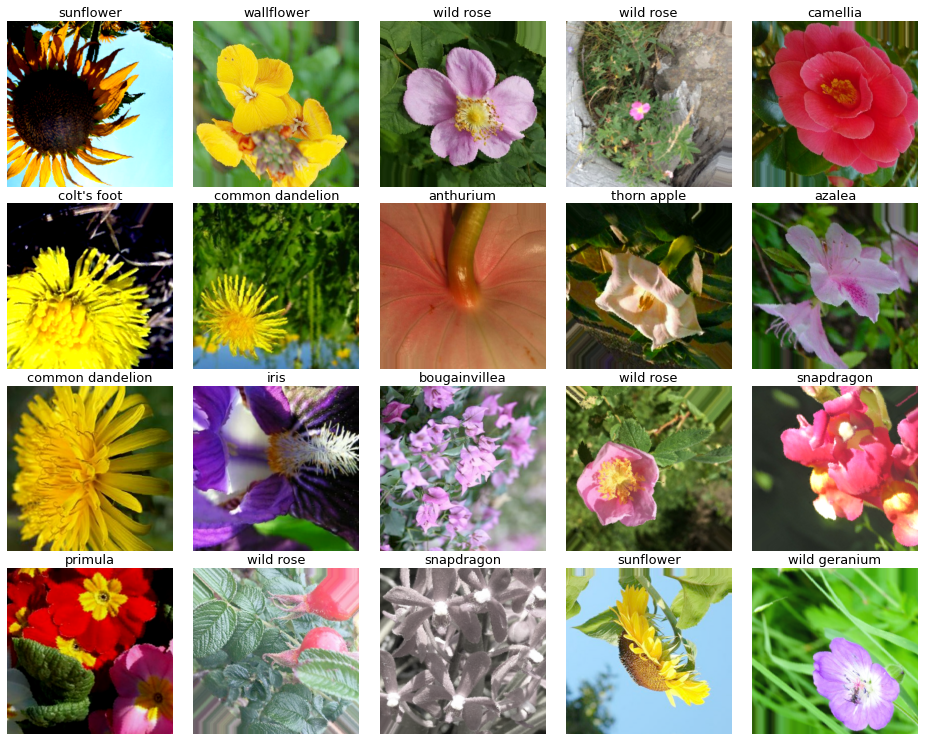

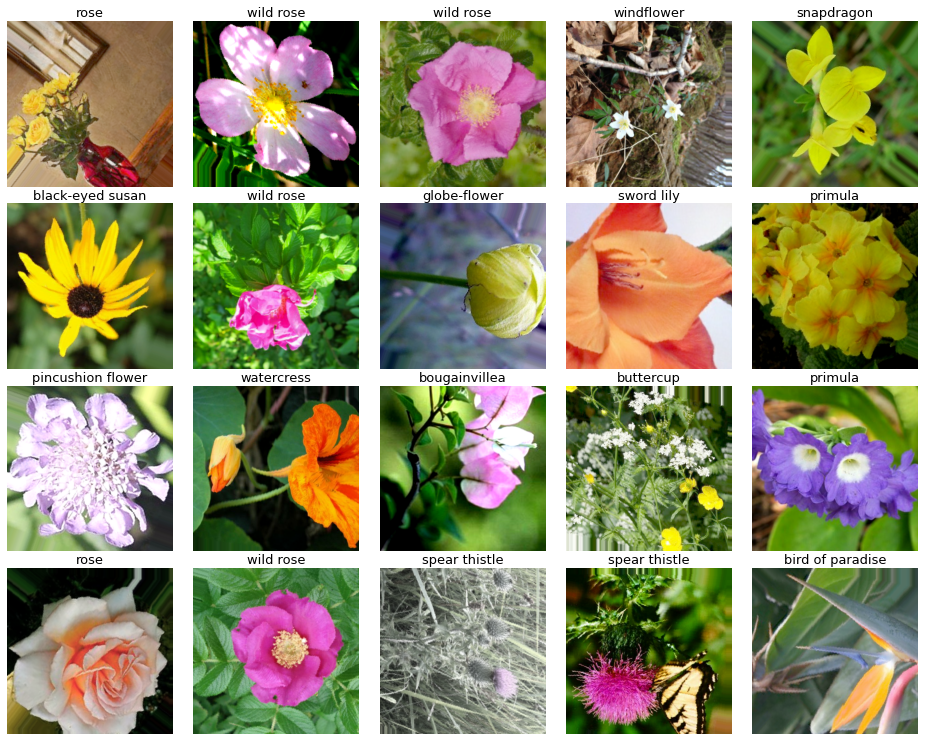

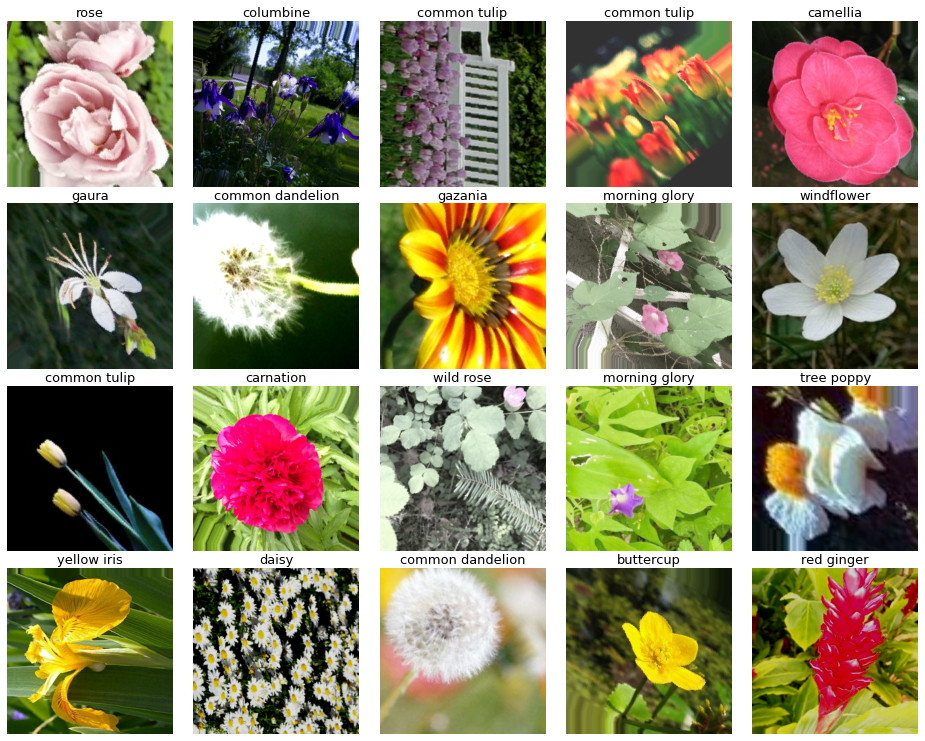

In [10]:
train_dataset_aug = get_dataset(TRAINING_FILENAMES, labeled=True, ordered=False, repeated=True, shufled=True, augmented=True)
display_batch_of_images(next(iter(train_dataset_aug.unbatch().batch(20))))
display_batch_of_images(next(iter(train_dataset_aug.unbatch().batch(20))))
display_batch_of_images(next(iter(train_dataset_aug.unbatch().batch(20))))

# Model (EfficientNet)

### EfficientNet has proven to be a very good baseline for many computer vision tasks

<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/EfficientNet_comparison.jpg' width='1000'></center>

In [11]:
def create_model(input_shape, N_CLASSES):
    base_model = efn.EfficientNetB4(weights='noisy-student', 
                                    include_top=False,
                                    input_shape=input_shape)

    model = tf.keras.Sequential([
                base_model,
                L.GlobalAveragePooling2D(),
                L.Dense(N_CLASSES, activation='softmax')
            ])
    
    
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=['sparse_categorical_accuracy'])
    
    return model

### Transfer learning

Here we are going to use a model pre-trained on [Imagenet](http://www.image-net.org/) but we are adding some extra layers at the top, and those layers have their weights randomly initialized, because of this, updating the complete network the regular way may mess up the pre-trained weights, so we need to use a strategy to try to avoid this, in this case, we are going to use a learning rate schedule with a warmup step.

<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/EfficientNet_transfer.png' width='1000'></center>

### Learning rate schedule (Exponential decay with warmup)

20 total epochs and 64 steps per epoch
Learning rate schedule: 1e-06 to 0.00024 to 6.76e-06


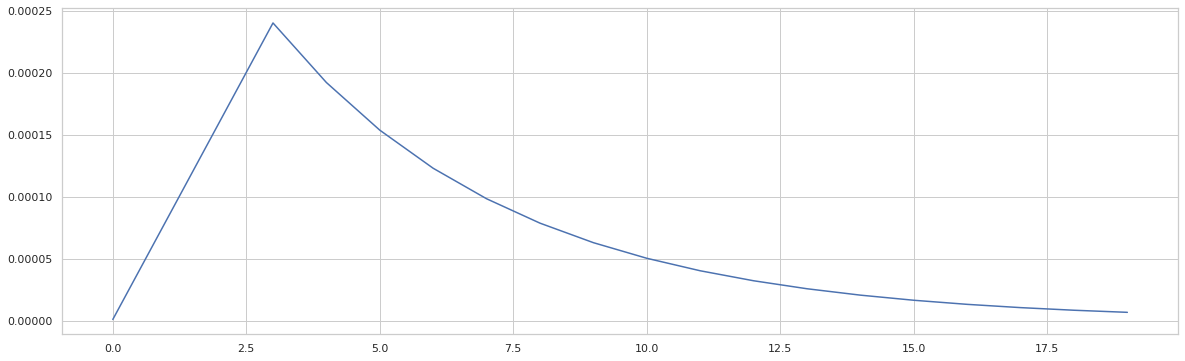

In [12]:
def exponential_schedule_with_warmup(epoch):
    '''
    Create a schedule with a learning rate that decreases exponentially after linearly increasing during a warmup period.
    '''
    
    warmup_epochs=3
    hold_max_epochs=0
    lr_start=1e-6
    lr_max=LEARNING_RATE
    lr_min=1e-6
    decay=0.8
        
        
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start
    elif epoch < warmup_epochs + hold_max_epochs:
        lr = lr_max
    else:
        lr = lr_max * (decay ** (epoch - warmup_epochs - hold_max_epochs))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)
            
    return lr

    
rng = [i for i in range(EPOCHS)]
y = [exponential_schedule_with_warmup(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to { max(y):.3g} to { y[-1]:.3g}')

# Train

In [13]:
kfold = KFold(N_FOLDS, shuffle=True, random_state=seed)
history_list = []; oof_y = []; oof_pred = []

# Datasets
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, ordered=True)
x_test = test_dataset.map(lambda image, idnum: image)
test_preds = np.zeros((NUM_TEST_IMAGES, N_CLASSES))


for n_fold, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold >= FOLDS_USED:
        break
        
    print(f'\nFOLD: {n_fold+1}')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    ### Data
    fold_train_filenames = np.asarray(TRAINING_FILENAMES)[trn_ind]
    fold_valid_filenames = np.asarray(TRAINING_FILENAMES)[val_ind]
    train_size = count_data_items(fold_train_filenames)
    validation_size = count_data_items(fold_valid_filenames)
    STEPS_PER_EPOCH = train_size // BATCH_SIZE
    oof_ds = get_dataset(fold_valid_filenames, labeled=True, ordered=True)

    ### Train model
    K.clear_session()
    model_path = f'model_{HEIGHT}x{WIDTH}_fold_{n_fold+1}.h5'

    with strategy.scope():
        model = create_model((None, None, CHANNELS), N_CLASSES)

    es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
    lr_callback = LearningRateScheduler(exponential_schedule_with_warmup, verbose=0)


    history = model.fit(x=get_dataset(fold_train_filenames, labeled=True, ordered=False, repeated=True, shufled=True, augmented=True), 
                        validation_data=get_dataset(fold_valid_filenames, labeled=True, ordered=True), 
                        callbacks=[checkpoint, es, lr_callback], 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        verbose=2).history
    
    history_list.append(history)
    
    # Inference
    test_preds += model.predict(x_test) / FOLDS_USED
    oof_y.append(np.array([target.numpy() for img, target in iter(oof_ds.unbatch())]))
    oof_pred.append(model.predict(oof_ds))
    
valid_pred = np.argmax(np.concatenate(oof_pred), axis=-1)
y_valid = np.concatenate(oof_y)
test_preds = np.argmax(test_preds, axis=-1)


FOLD: 1
71680000/71678424 [==============================] - 3s 0us/step
Epoch 1/20
49/49 - 54s - loss: 4.6618 - sparse_categorical_accuracy: 0.0120 - val_loss: 4.6658 - val_sparse_categorical_accuracy: 0.0036 - lr: 1.0000e-06
Epoch 2/20
49/49 - 32s - loss: 4.0601 - sparse_categorical_accuracy: 0.2042 - val_loss: 3.3889 - val_sparse_categorical_accuracy: 0.3176 - lr: 8.0667e-05
Epoch 3/20
49/49 - 31s - loss: 2.1801 - sparse_categorical_accuracy: 0.5204 - val_loss: 1.5654 - val_sparse_categorical_accuracy: 0.6448 - lr: 1.6033e-04
Epoch 4/20
49/49 - 30s - loss: 1.0084 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.8261 - lr: 2.4000e-04
Epoch 5/20
49/49 - 30s - loss: 0.6127 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.4752 - val_sparse_categorical_accuracy: 0.8830 - lr: 1.9200e-04
Epoch 6/20
49/49 - 31s - loss: 0.4550 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.3497 - val_sparse_categorical_accuracy: 0.9084 - lr: 1.5360e-04
Ep

## Model loss graph

FOLD 1


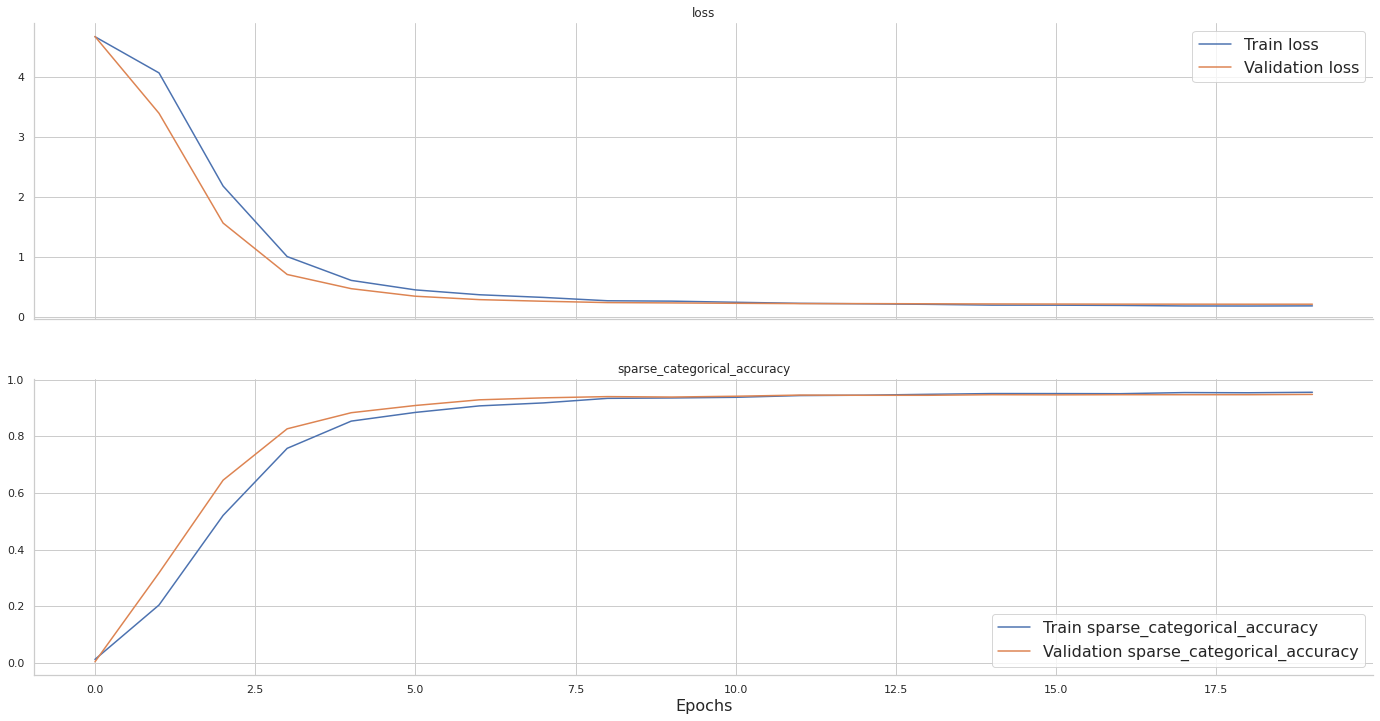

FOLD 2


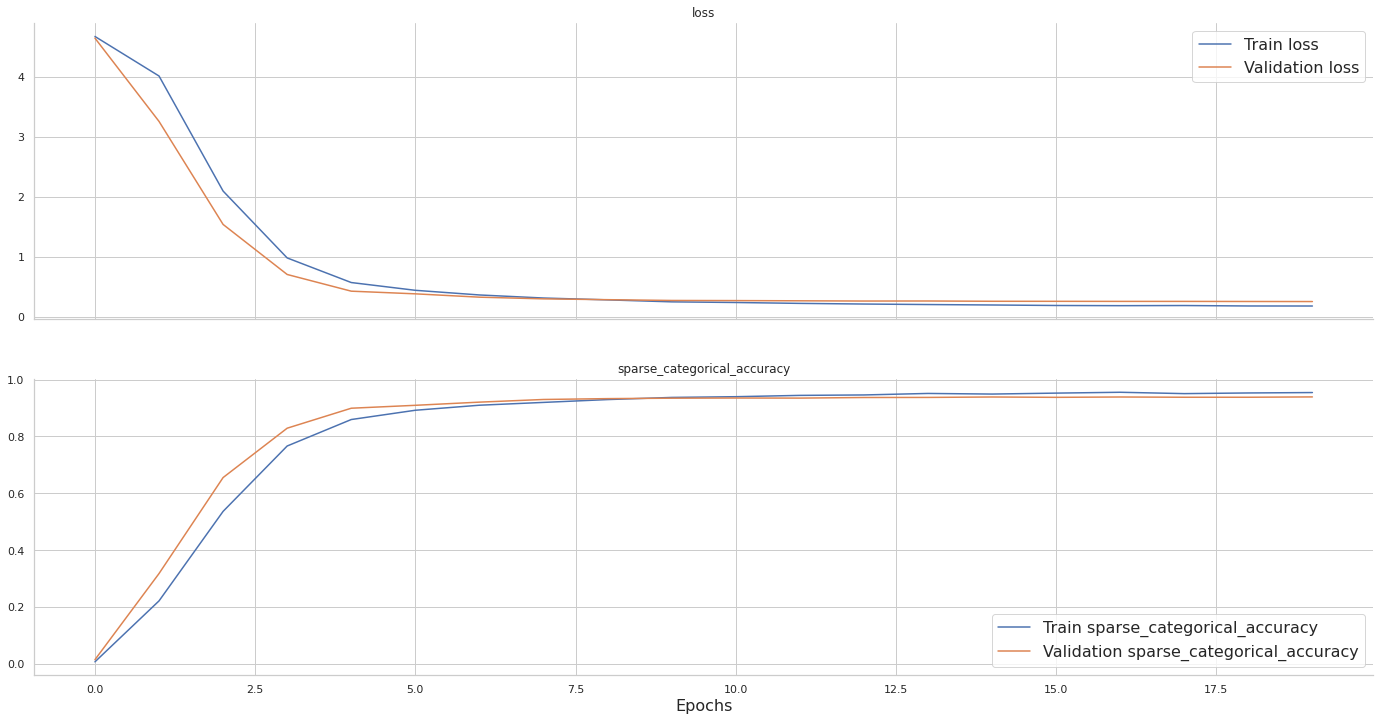

FOLD 3


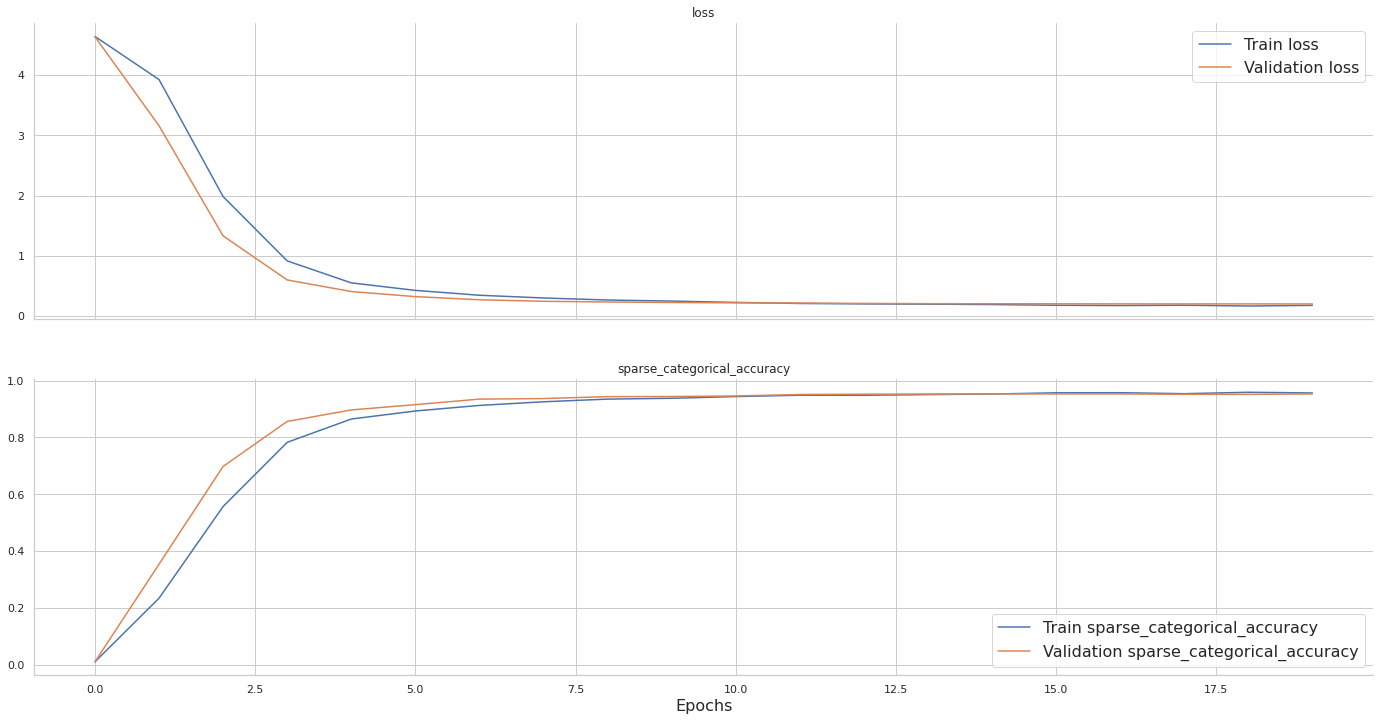

FOLD 4


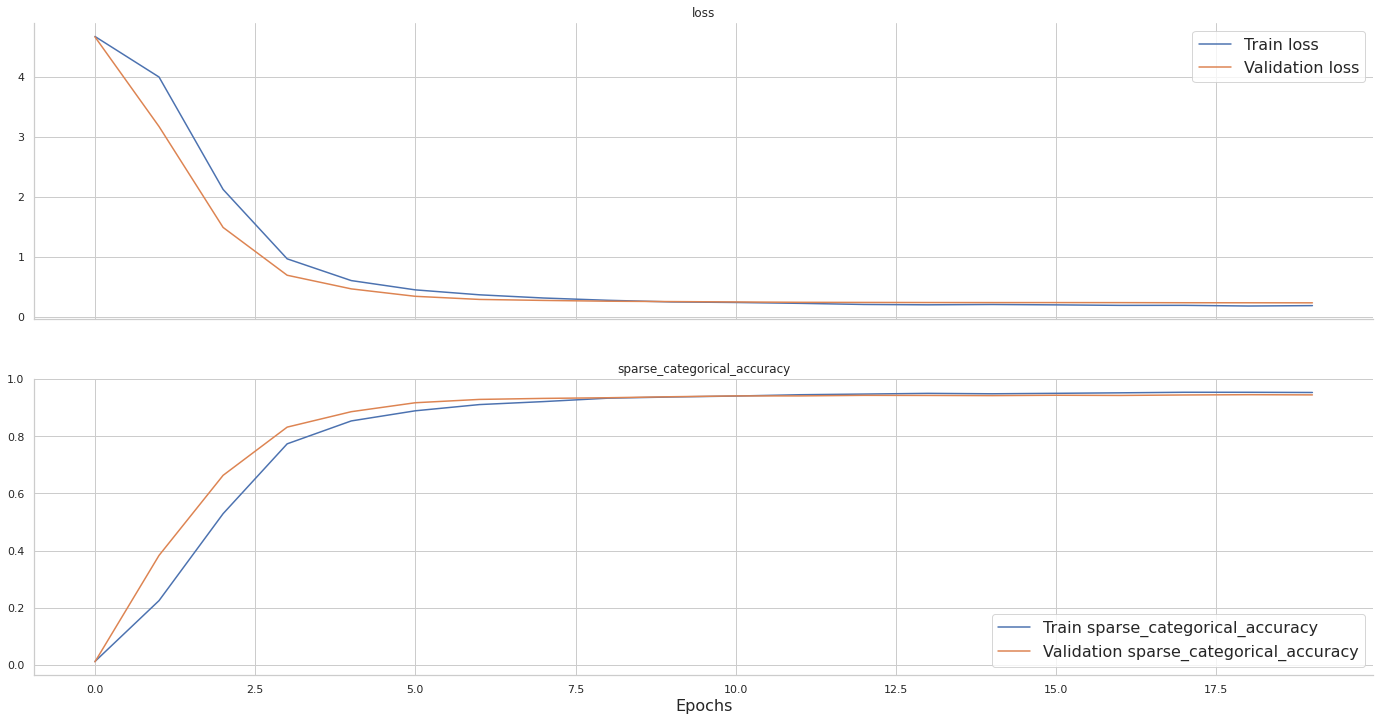

FOLD 5


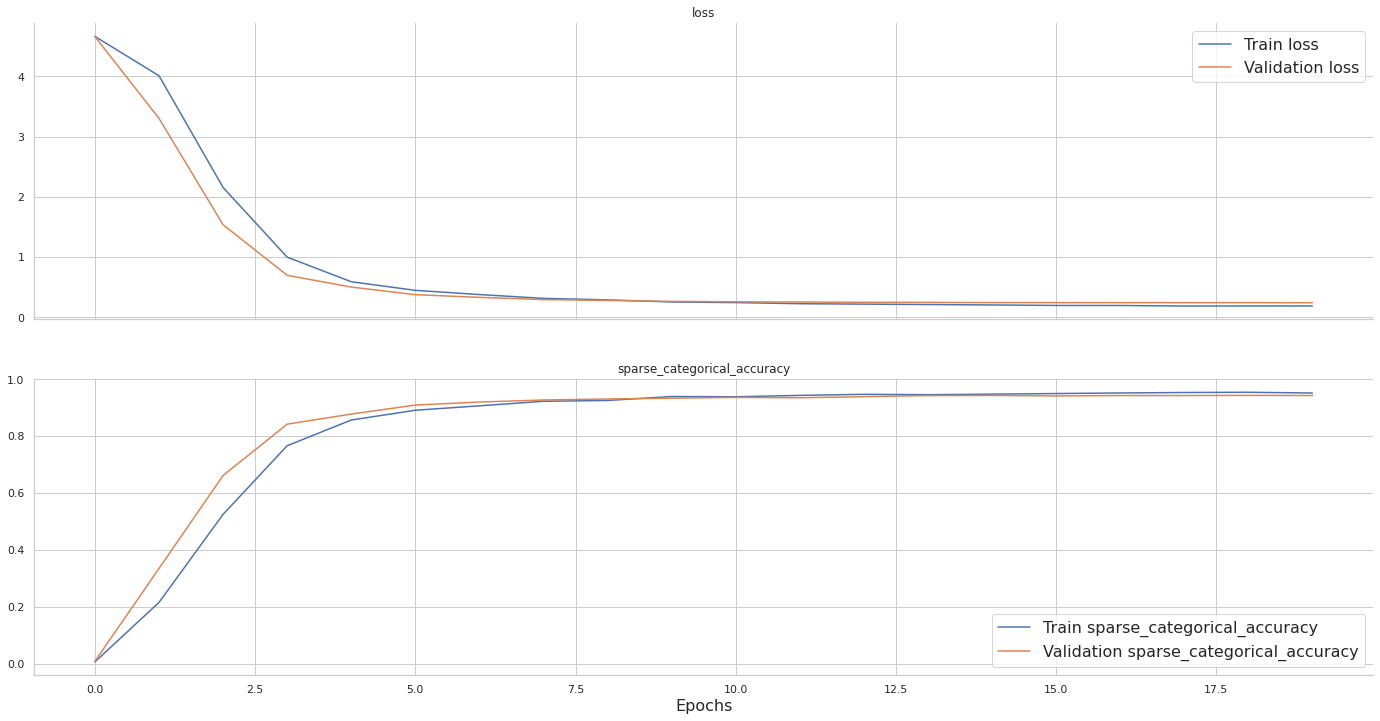

In [14]:
for index, history in enumerate(history_list):
    print(f'FOLD {index+1}')
    plot_metrics(history, metric_list=['loss', 'sparse_categorical_accuracy'])

# Model evaluation

In [15]:
print(classification_report(y_valid, valid_pred, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       0.98      0.96      0.97       351
hard-leaved pocket orchid       1.00      1.00      1.00        33
         canterbury bells       0.83      0.73      0.78        26
                sweet pea       0.47      0.26      0.33        27
            wild geranium       0.95      0.99      0.97       908
               tiger lily       0.94      0.89      0.92       112
              moon orchid       0.96      0.96      0.96        23
         bird of paradise       0.98      0.99      0.98       136
                monkshood       0.94      0.90      0.92       112
            globe thistle       0.95      0.96      0.96       108
               snapdragon       0.92      0.89      0.90       176
              colt's foot       0.98      1.00      0.99        56
              king protea       0.97      0.94      0.95       119
            spear thistle       0.96      0.99      0.97     

# Confusion matrix

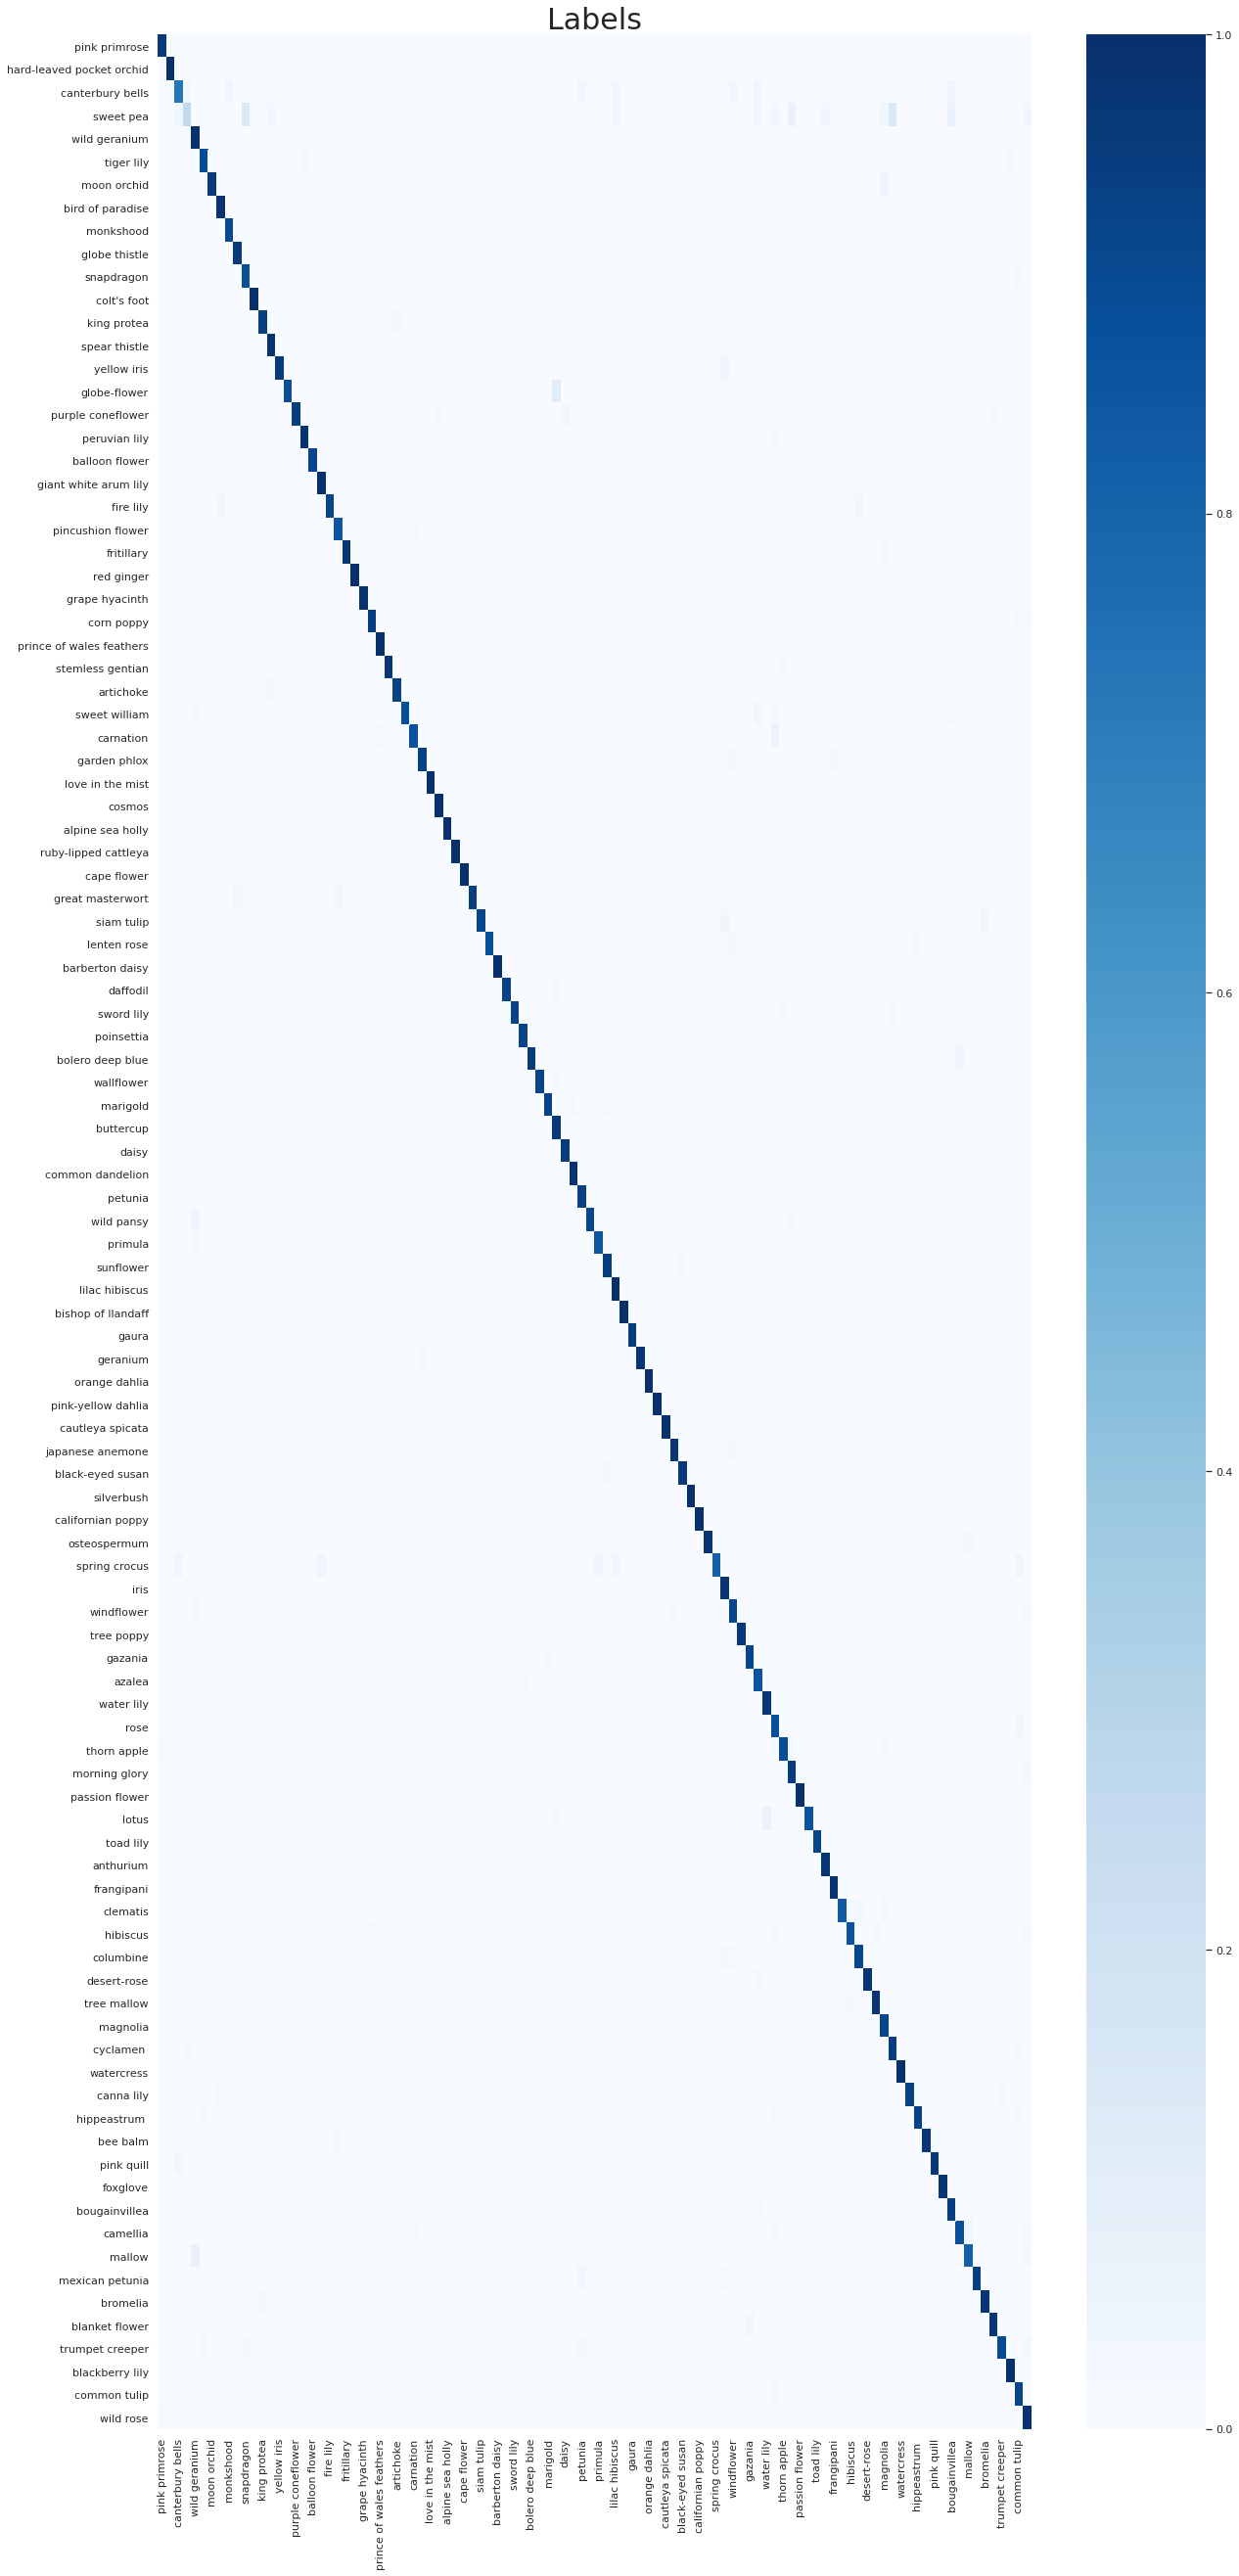

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 45))
cfn_matrix = confusion_matrix(y_valid, valid_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues').set_title('Labels', fontsize=30)
plt.show()

# Visualize predictions

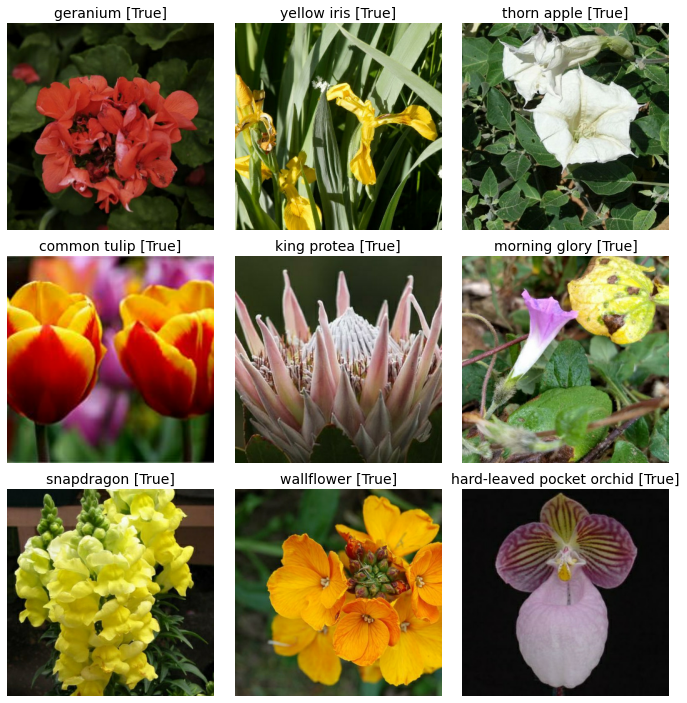

In [17]:
x_samp, y_samp = dataset_to_numpy_util(oof_ds, 9)
samp_preds = model.predict(x_samp, batch_size=9)
display_9_images_with_predictions(x_samp, samp_preds, y_samp)

# Test set predictions

In [18]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

id  label
0  252d840db     67
1  1c4736dea     28
2  c37a6f3e9     83
3  00e4f514e    103
4  59d1b6146     40
5  8d808a07b     53
6  aeb67eefb     52
7  53cfc6586     29
8  aaa580243     82
9  d907ca7c0     13